## Larry

Apply Kepert to Larry

Compare with IWRAP

TODO: Peu de données avion proches de la surface. Si je veux caler mon champ de vent il va falloir que j'utilise les données en z du Kepert. Donc coder le Kepert en z. C'est prioritaire par rapport au epsilon ou au côtier.

TODO: Recaler l'avion sur le champ de vents SAR en supposant que le champ de vents a translaté (mais n'a pas tourné) durant cet intervale de temps. Utiliser la prochaine position du SAR pour calculer la vitesse, plus élégant que d'utiliser les best-tracks

Attention aussi, Kepert n'a pas de w, il utilise Ekman, et donc son w ne dépend que de C (et K par u, v), ce qui fait que C et K n'ont plus un rôle symétrique. Vérifier que dans IWRAP w est mesuré indépendamment de u, v. Si c'est le cas, je peux tenter de calibrer à la fois C et K sur Larry, en utilisant SAR+IWRAP.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'iwp_dir': '/home/arthur/data/tropical_cyclones/IWRAP/',
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    # 'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/02_plotKepertAndSARasymmetries/',
}

In [3]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Open Larry
ds  = dsg.where(dsg.name == 'LARRY', drop=True).sortby('time').isel(time=4)
dsp = xr.open_dataset(PTHS['sar_dir'] + 's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone_polar.nc').isel(time=0)

In [20]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * eta(Rs, Vs, K, C, fcor) + 3j * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * psi(Rs, Vs, K, C, fcor) + 3j * eta(Rs, Vs, K, C, fcor)]
    return num / den

def A1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def u0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    v0 = np.imag(A0(Rs, Vs, K, C, fcor))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return u_1(THs, Rs, Vs, Ut, K, C, fcor) + u0(Rs, Vs, K, C, fcor) + u1(THs, Rs, Vs, Ut, K, C, fcor)

def v_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return Vs + v_1(THs, Rs, Vs, Ut, K, C, fcor) + v0(Rs, Vs, K, C, fcor) + v1(THs, Rs, Vs, Ut, K, C, fcor)

# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor)  

    # Adds the translation speed
    Utu     = Ut * np.cos(THs) # Radial component of Ut
    Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # Utu = Utv = 0
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)

    # Compute asymmetries on Kepert wind field
    aks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, _, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
    
    return aks, kep_pol

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [5]:
# # Create dataset
# dsa = xr.Dataset(
#     data_vars={
#         'wn1':            ('rad', ASS),
#         'wn1_avgTH':      ('rad', AS2),
#         'wn1_avgTHandR':  ('rad', AS3),
#         'wn1_err':        ('rad', ERR),
#         'valid_thetas':   ('rad', VTS),
#         'quantile_diff':  ('rad', ASQ),
#         'inertial_ratio': ('rad', first_term_eq5_k01 / secnd_term_eq5_k01),
#         'translat_ratio': ('rad', float(ds.speed) / Vs[0, idxs]),
#         'I_Vr1':          r_stt,
#         'I_Vr2':          r_end,
#     },
#     coords={
#         'time': ds.time,
#         'rad': xs
#     }
# )

In [9]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

xs           = np.linspace(1000, 250000, 250)

# BL characteristics
C  = 1.5e-3            # fixed
# Ks = [1, 50, 100, 150] # trial
Ks = [10, 20, 30, 40, 50, 100, 150] # trial
# Ks = [100]

# Colors
truncated_Reds = truncate_colormap(mpl.cm.Reds, 0.2, 1.)
colors         = truncated_Reds(np.linspace(0, 1, len(Ks)))

In [10]:
# Fixed parameters
vmx = float(ds.vmx_hol)
rmx = float(ds.rmx_hol)
vmn = float(ds.vmn_hol)
B   = float(ds.B_hol)
lat = float(ds.lat)
fcr = abs(float(ds.fcor))
Ut  = float(ds.speed)

# Holland with fixed parameters
V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

# # I ~ V/r radii
# try:
#     I_Vr         = (I(Rs, Vs, fcr) - Vs / rs)[0, :]    # I - V/r
#     r_stt, r_end = rs[I_Vr <= 0][0], rs[I_Vr <= 0][-1] # Define the bounds
# except IndexError:
#     r_stt = r_end = np.nan

# Prepare averagings
timescale   = 1 / I(Rs, Vs, fcr)[0, :]             # time needed for the BL to develop
radialscale = timescale * Vs[0, :] / 5             # radial distance travelled by an air parcel in the meantime, considering that U/V = 5
tangenscale = timescale * Vs[0, :]                 # tangential distance travelled by an air parcel in the meantime
thetascale  = 360 * tangenscale / (2 * np.pi * rs) # convert this tangential distance to theta
thetascale[np.isnan(thetascale)] = 9999            # # happens when time 1/I explodes, so put a high value to enter the ValueError exception below (AS2 and AS3 computation)

# print(t, ds.file.item())

# x-axis
# xs = np.linspace(ds.rmx, 2 * ds.rps, 50)
# xs = np.linspace(ds.rmx, 2 * ds.rps, 10)
# xs = np.linspace(1000, 250000, 250)[::100]
xs = np.linspace(1000, 250000, 250)

# Asymmetries
ASS  = []
AS2  = []
AS3  = []
ASQ  = []
rads = []
ERR  = []
VTS  = []
for rad in tqdm(xs):
    try:
        # dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)).plot()
        # ass, _, _ = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)), float(ds.vps), float(ds.vmx))
        valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
        ass, phi, c   = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, float(ds.vps), float(ds.vmx))
        error         = float(rmse(wn1(np.deg2rad(valid_dsp.theta), ass, phi, c), valid_dsp.wind_speed)) 
        ASS.append(ass)
        ERR.append(error)
        VTS.append(len(valid_dsp.theta))

        # Preparing averagings
        avg_on_u = radialscale[rs >= rad][0]
        avg_on_v = int(thetascale[rs >= rad][0])

        try:
            # Average on theta
            valid_dsp2      = dsp.sel(rad=rad, method='nearest').rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(subset=['wind_speed'], dim='theta')
            as2, phi2, c2   = get_wn1(np.deg2rad(valid_dsp2.theta), valid_dsp2.wind_speed, float(ds.vps), float(ds.vmx))
            AS2.append(as2)

            # Average on theta AND r
            valid_dsp3      = dsp.sel(rad=slice(rad - avg_on_u, rad + avg_on_u))[['wind_speed']].mean(dim='rad', skipna=True).rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(dim='theta')
            as3, phi3, c3   = get_wn1(np.deg2rad(valid_dsp3.theta), valid_dsp3.wind_speed, float(ds.vps), float(ds.vmx))
            AS3.append(as3)
            
        except ValueError:
            # happens when time 1/I explodes, such that to average on theta we would average on more than 361 values of theta!
            as2 = as3 = np.nan
            AS2.append(as2)
            AS3.append(as3)

        # Add radius
        rads.append(rad)

    except RuntimeError:
        print('RuntimeError when computing the asymmetries.')
        break
    # Asymmetries with the quantiles
    a_qtl = dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.9) - dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.1)
    ASQ.append(a_qtl)
    
# Inertial neutrality?
dr                 = np.diff(Rs[0, :])[0] # meteRs
dM_dr              = Vs + Rs * np.gradient(Vs, dr, axis=1) + fcr * Rs
beta               = dM_dr[0, :] / rs
u_in               = (0.5 * Vs[0, :] / (2 * float(ds.rps))) * rs
u_out              = 0.5 * Vs[0, :]
u                  = np.ones_like(Vs[0, :])
msk                = rs <= 2 * float(ds.rps)
u[msk]             = u_in[msk]   # Assume that u/v ~ r   on [0, 2R+]
u[~msk]            = u_out[~msk] # Assume that u/v = 0.5 on [2R+, infty]
idxs               = np.searchsorted(rs, xs)
secnd_term_eq5_k01 = u[idxs] * beta[idxs]
first_term_eq5_k01 = (Vs[0, idxs] / rs[idxs]) * (np.array(AS3) / (2 * np.pi))

  0%|          | 0/250 [00:00<?, ?it/s]

In [11]:
# Kepert model
AKS      = dict.fromkeys(Ks)
KEP_POLS = dict.fromkeys(Ks)
for i, K in enumerate(tqdm(Ks)):
    aks, kep_pol = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, xs)
    AKS[K]       = aks
    KEP_POLS[K]  = kep_pol

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_14908/2337020021.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('PuOr') # Spectral


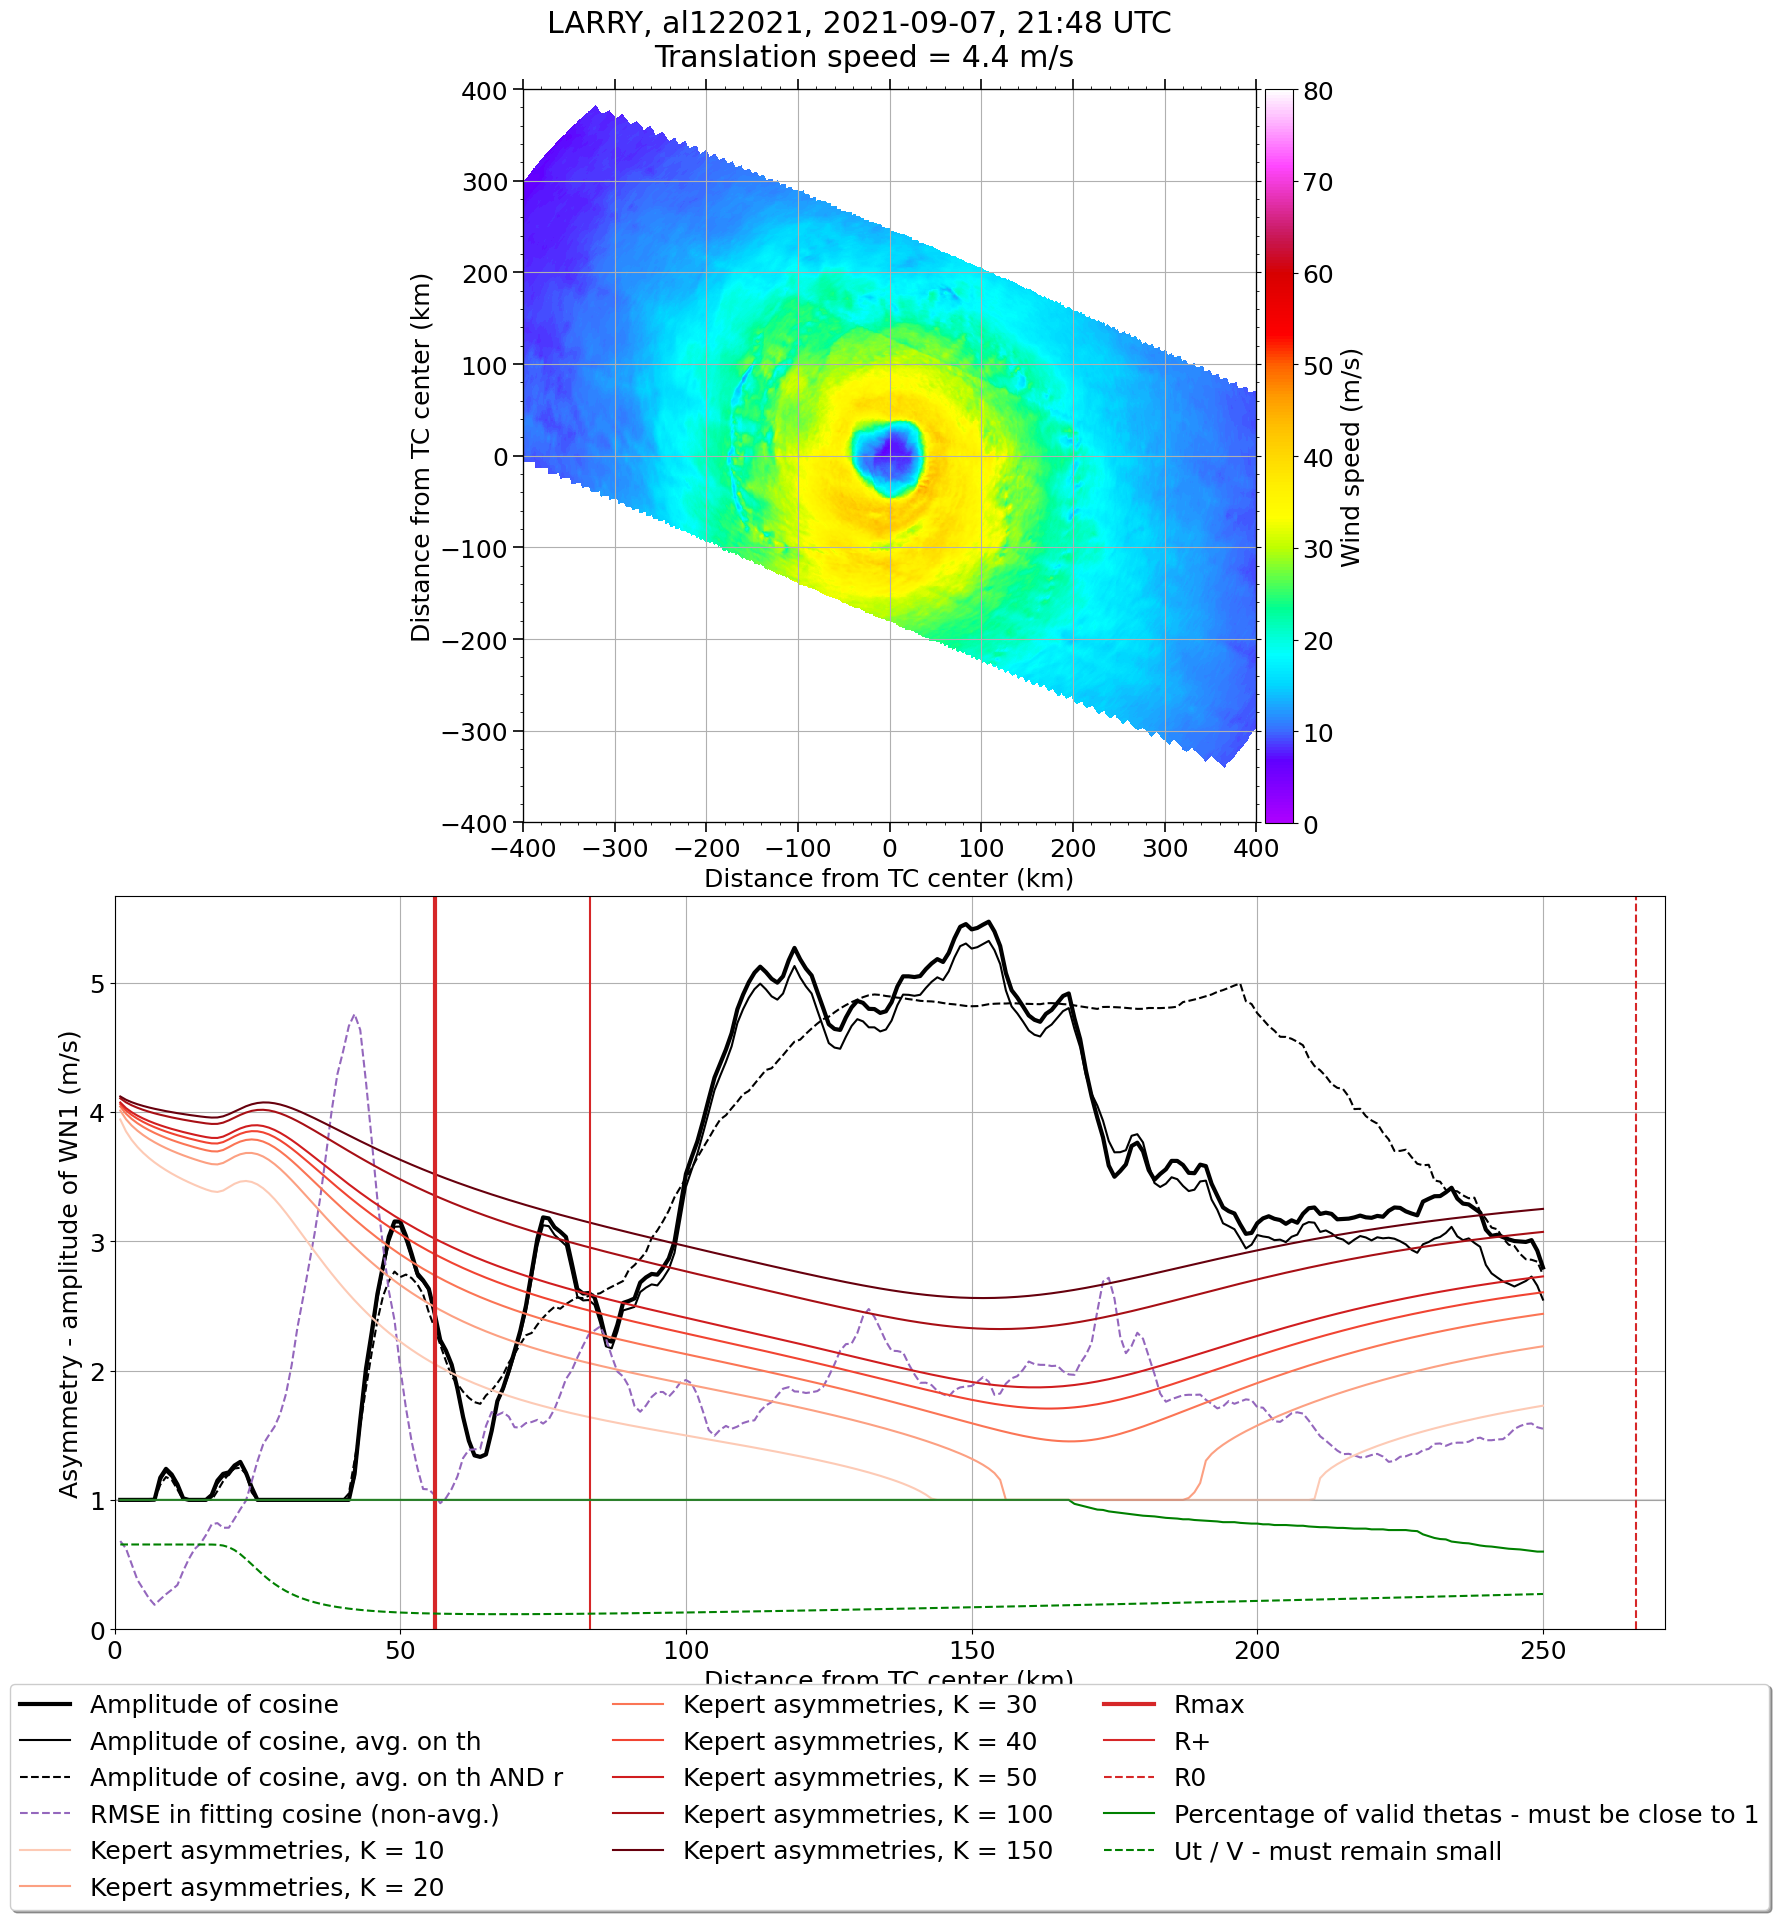

In [12]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = mpl.cm.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 400
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
ds_x, ds_y   = pol2cart(dr, th)
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Plot asymmetries (SAR + Kepert)
ax       = fig.add_subplot(gs[1, 0])

ax.plot(xs / 1000, ASS, c='k',          linewidth=3,        label='Amplitude of cosine')
ax.plot(xs / 1000, AS2, c='k',                              label='Amplitude of cosine, avg. on th')
ax.plot(xs / 1000, AS3, c='k',          linestyle='dashed', label='Amplitude of cosine, avg. on th AND r')
ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
# ax.plot(ds.rad / 1000, ds.quantile_diff,       c='tab:blue',   linewidth=3,        label='10%-quantile difference')
# Kepert asymmetry profiles
for i, K in enumerate(Ks):
    ax.plot(xs / 1000, AKS[K],                 c=colors[i],                        label='Kepert asymmetries, K = {}'.format(K))
# Wind radii
ax.axvline(ds.rmx / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
ax.axvline(ds.rps / 1000,                      c='tab:red',                        label='R+')
ax.axvline(ds.r0 / 1000,                       c='tab:red',    linestyle='dashed', label='R0')

# # I ~ V/r
# ax.axvline(ds.I_Vr1 / 1000,                    c='orange',                         label='I ~ V/r with SAR wind speed (not BL-top)')
# ax.axvline(ds.I_Vr2 / 1000,                    c='orange')

# Validity curves
# ax.plot(xs / 1000, first_term_eq5_k01 / secnd_term_eq5_k01,      c='green',      linewidth=3,        label='Inertial ratio - must be close to 1')
ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
ax.axhline(1, c='gray', alpha=0.3)

# Legends
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel('Asymmetry - amplitude of WN1 (m/s)')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fancybox=True, shadow=True)
ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
ax.set_ylim(0, 0.2 + float(max(max(ASS), max(ERR))))
ax.grid()

Good fit in terms of wind speeds, for both K = 10 and K = 50 (and the others).

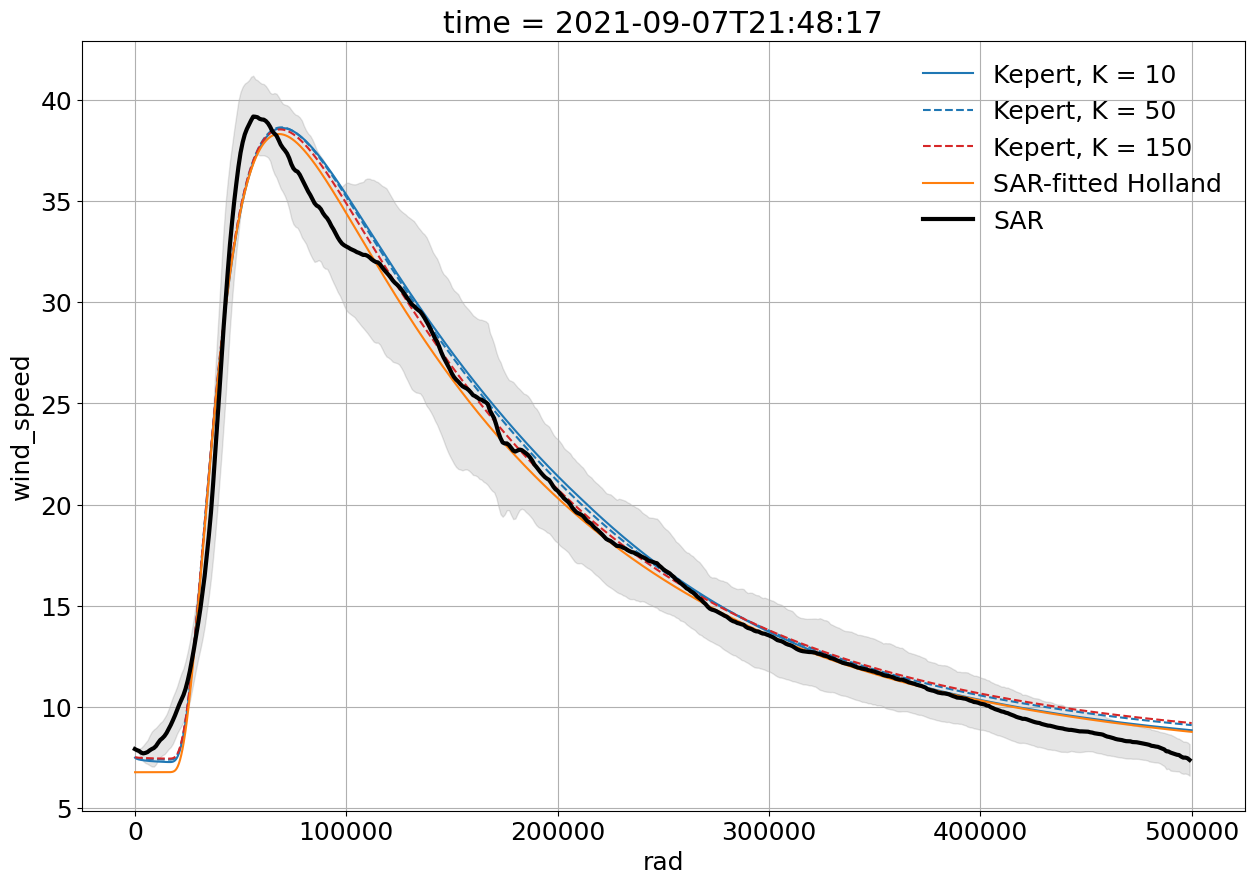

In [13]:
wsm = dsp.wind_speed.mean(dim='theta')
wss = dsp.wind_speed.std(dim='theta')

KEP_POLS[10].wind_speed.mean(dim='theta', skipna=True).plot(c='tab:blue', label='Kepert, K = 10')
KEP_POLS[50].wind_speed.mean(dim='theta', skipna=True).plot(c='tab:blue', label='Kepert, K = 50', linestyle='dashed')
KEP_POLS[150].wind_speed.mean(dim='theta', skipna=True).plot(c='tab:red', label='Kepert, K = 150', linestyle='dashed')
plt.plot(rs, V, c='tab:orange', label='SAR-fitted Holland')
wsm.plot(c='k', linewidth=3, label='SAR')
plt.fill_between(wsm.rad, wsm - wss, wsm + wss, color='k', alpha=0.1)
plt.legend(frameon=False)
plt.grid()

Almost no difference in terms of inflow angle between K = 10 and K = 50.

Thus, in what follows I use K = 20, as if the asymetries were fitted only at r=Rmax.

In [14]:
a10  = np.rad2deg(np.arctan(abs(KEP_POLS[10].rad_wind) / abs(KEP_POLS[10].tan_wind)))
a50  = np.rad2deg(np.arctan(abs(KEP_POLS[50].rad_wind) / abs(KEP_POLS[50].tan_wind)))
a150 = np.rad2deg(np.arctan(abs(KEP_POLS[150].rad_wind) / abs(KEP_POLS[150].tan_wind)))

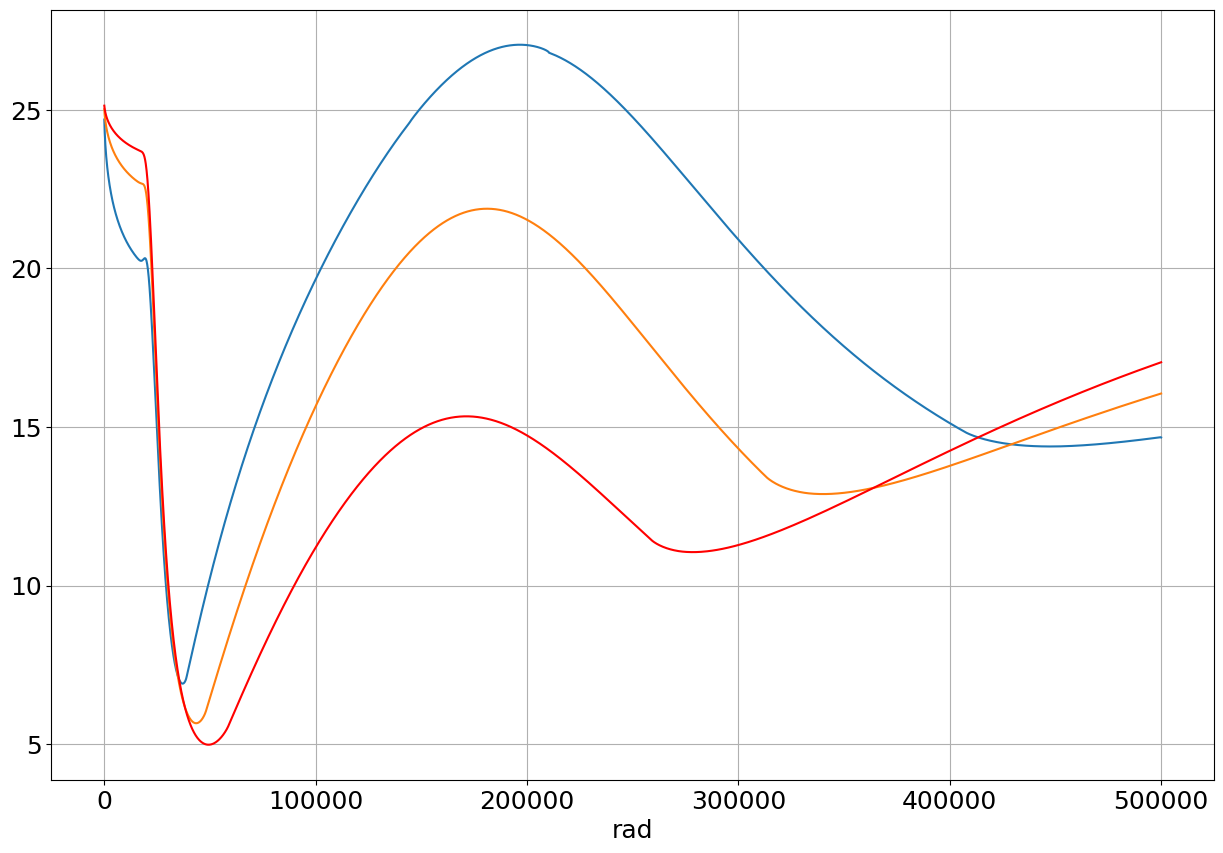

In [15]:
a10.mean(dim='theta').plot()
a50.mean(dim='theta').plot()
a150.mean(dim='theta').plot(c='r')
plt.grid()

In [16]:
# May lasts a few seconds
kep_car = get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, KEP_POLS[20])

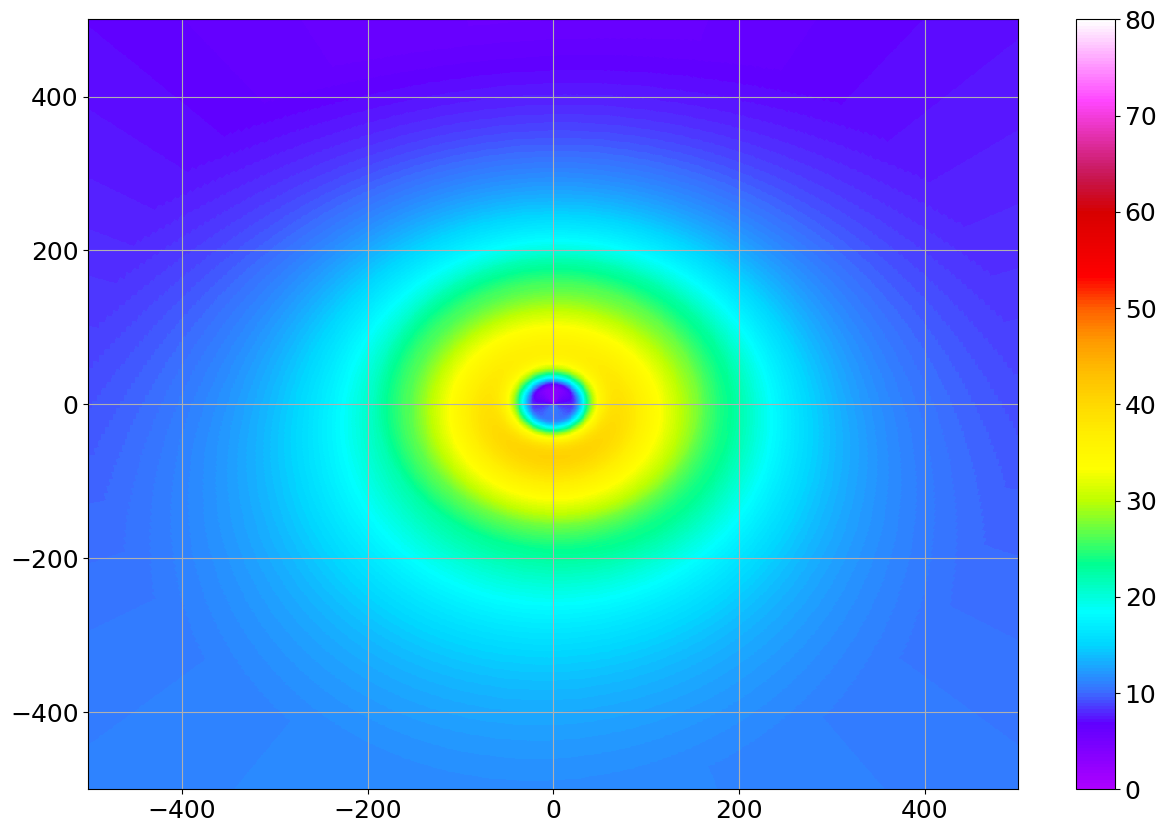

In [17]:
plt.pcolormesh(kep_car.x / 1000, kep_car.y / 1000, kep_car.wind_speed, cmap=cwnd, norm=normalizer)
plt.colorbar()
plt.grid()

### IWRAP

In [66]:
diwp1 = xr.open_dataset(PTHS['iwp_dir'] + 'IWRAP_3Dsp_ku1_20210907I1_20230522T193045.nc')
diwp2 = xr.open_dataset(PTHS['iwp_dir'] + 'IWRAP_3Dsp_ku2_20210907I1_20230522T175900.nc')
diwp3 = xr.open_dataset(PTHS['iwp_dir'] + 'IWRAP_3Dsp_ku2_20210907I1_20230531T173056.nc')

# Filter data (cf. mail Joe Sapp)
# diwp1 = diwp1.where(diwp1.quality >= 7)
# diwp2 = diwp2.where(diwp1.quality >= 7)
# diwp3 = diwp3.where(diwp1.quality >= 7)

(array([   0.,    0.,    0.,    0.,    0., 4196.,    0.,    0.,    0.,
           0.]),
 array([3.5       , 3.5999999 , 3.70000005, 3.79999995, 3.9000001 ,
        4.        , 4.0999999 , 4.19999981, 4.30000019, 4.4000001 ,
        4.5       ]),
 <BarContainer object of 10 artists>)

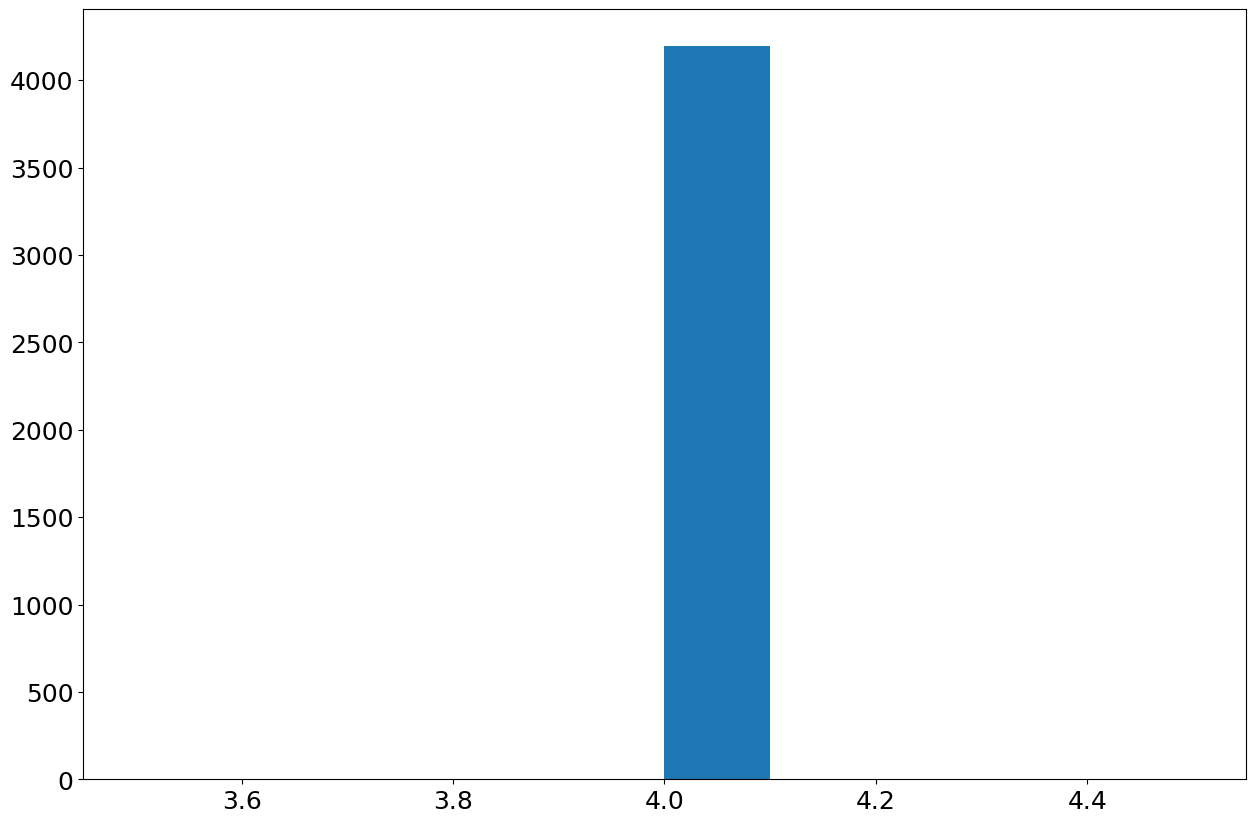

In [75]:
plt.hist(np.array(diwp1.quality).flatten())

In [67]:
np.count_nonzero(~np.isnan(diwp1.w))

287987

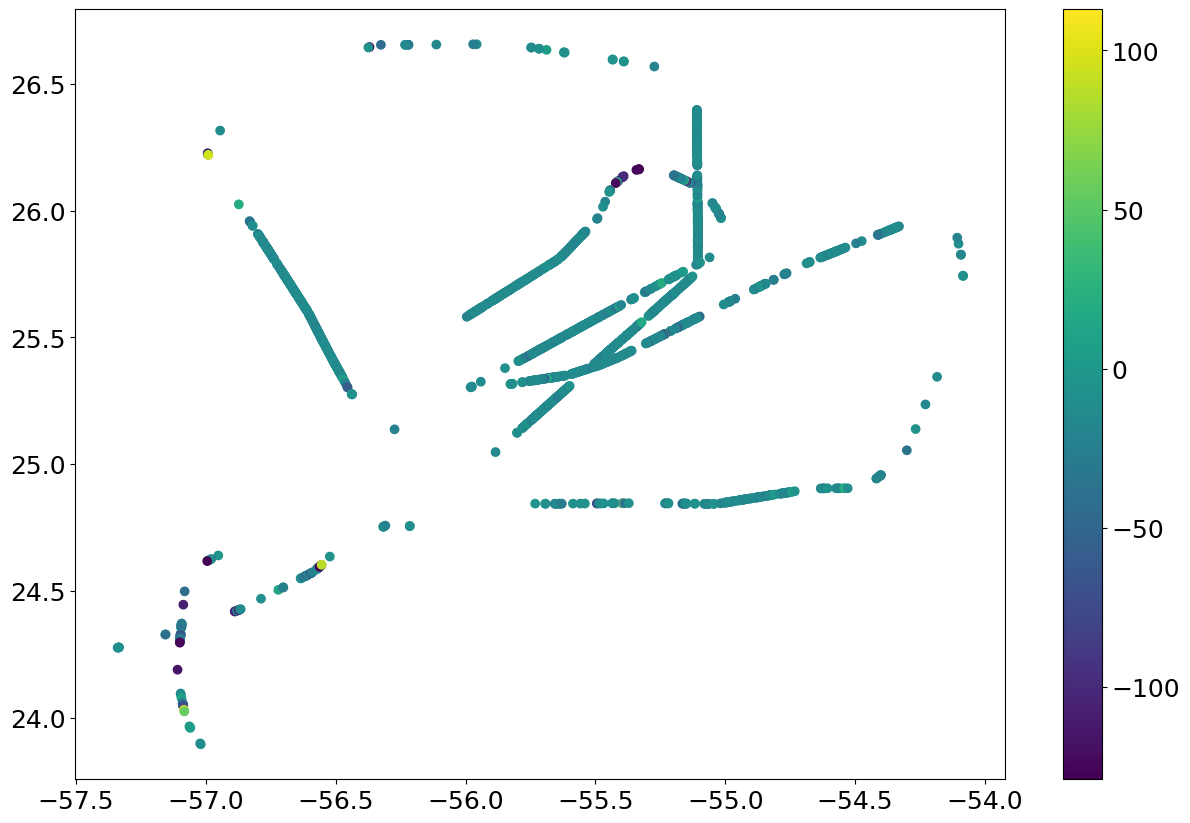

In [70]:
plt.scatter(diwp1.isel(height=1).lon, diwp1.isel(height=1).lat, c=diwp1.isel(height=1).w)
plt.colorbar()

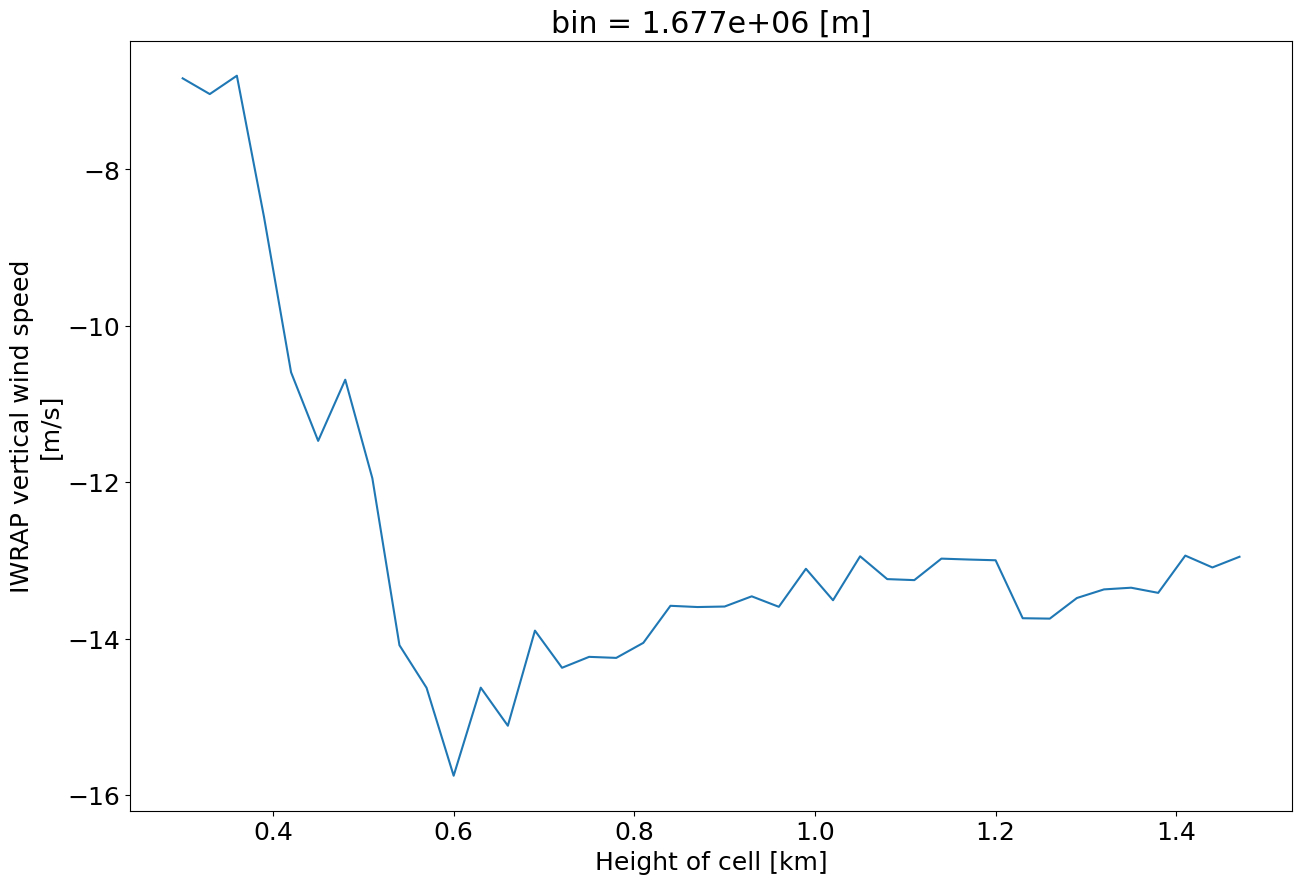

In [219]:
diwp1.isel(bin=4000).w.plot()

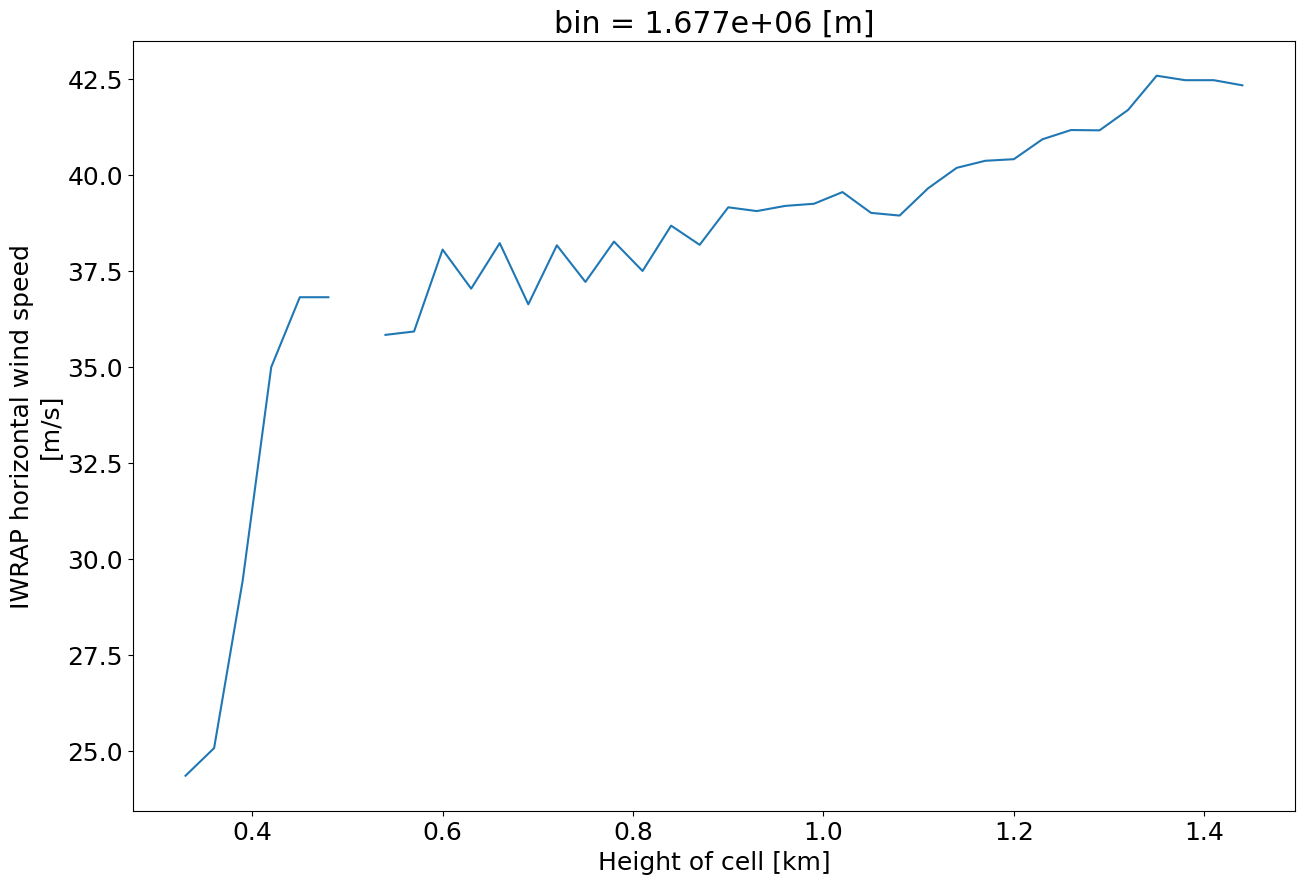

In [223]:
diwp1.isel(bin=4000).hws.plot()

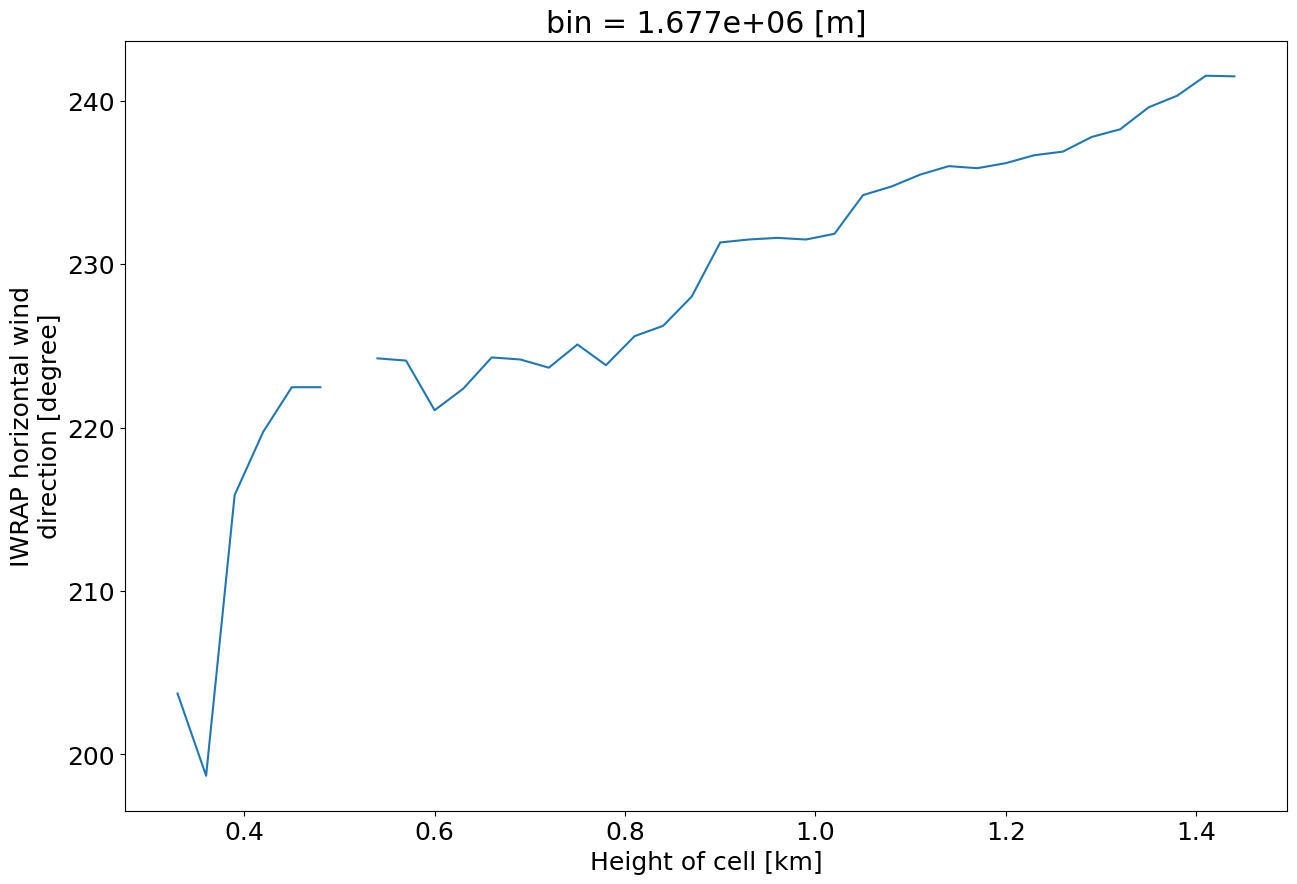

In [224]:
diwp1.isel(bin=4000).hwdir.plot()

In [84]:
diwp3.bin

<xarray.DataArray 'bin' (bin: 11352)> Size: 91kB
array([1009350., 1009500., 1009650., ..., 2991300., 2991450., 2991600.],
      shape=(11352,))
Coordinates:
  * bin      (bin) float64 91kB 1.009e+06 1.01e+06 ... 2.991e+06 2.992e+06
Attributes:
    long_name:    Center of cell in alongtrack distance traveled
    units:        m
    valid_range:  [                  0 9223372036854775807]